# Indexing Music
This Jupyter notebook was created by Hitesh WALIA & Philipp BEHRENDT

## Data Collection and Feature Extraction 

In a very first step, we collected several Midi-Files of popular [TV-Themes](http://www.midiworld.com/search/1/?q=tv%20themes). Secondly, we selected several musical features from the different music pieces, which we will explain shortly. To extract these features, we mainly build on the code of following [repository](https://github.com/angelfaraldo/pymidifile). It uses two python libs that cope with music and in particular midi-files (mido, music21). Please install them before running this notebook- otherwise we use commonly used stan.  Nonetheless, we slightly adapted the code and implemented few functions to process features (e.g. for the intervall-histogram). Please note, that we are not too familiar with music theory, that our choices of features might be misleading. We have chosen some features from the instructions. Furthermore, we considered the relative steps between pitches as important for a harmony and by that an very essential part of music. Thus, we extracted the interval vector and a histogram of occuring intervals as additional features. In total, our seleted features are the following: 

- Length of the piece in bars (*len*)
- Average events per bar (*aveb*)
- Range of pitches in semi-tones (*rng*)
- Highest Pitch (*hip*)
- Average time between attacks (*ata*)
- Interval Vector (*ivv*)
- Harmony Signature (*harm*)
- Set of instrumentes (*ins*)
- Tempo of the bar (*tb*)
- Pitch histogram (*phist*)
- Interval histogram (*ihist*)



In [19]:
import seaborn as sns
import numpy as np
import itertools as it
import re
import warnings
import matplotlib.pyplot as plt
from pymidifile import *
from pandas import Series as s, DataFrame as df
from numpy.linalg import norm
from tqdm import tqdm
import scipy.stats as st
import statsmodels as sm

In [20]:
# Helper Functions to extract features - adapted from https://github.com/angelfaraldo/pymidifile

def calculate_features(mid):
    """
    Extract musical features from a midi file.

    Parameters
    ----------
    mid: str
        Valid path to a midi file.

    Return
    ------
    features
        a pandas series with the results of the analysis

    """

    # Preprocession - Load and parse 
    music = m21.converter.parseFile(mid, format('midi'))
    midi_raw = parse_mid(mid)
      
    # set up dictionary for an individual midi
    features = dict()
    features['piece'] = re.sub(".*\\\TV_Themes_-_", "", mid)
    
    # get all pitches as sequence as raw and as modulu 
    seq = m21.chord.Chord(music.flat.pitches)
    midi_seq_raw = [event.midi for event in seq.pitches]
    midi_seq = [pitch%12 for pitch in midi_seq_raw]
    
    # interval between last and first note
    li = seq[0].pitch.midi - seq[-1].pitch.midi
    
    # length in bars
    features['len'] = dur_in_bars(midi_raw)
    
    # total number of events - auxiliary 
    ne = len(seq)

    # average events per bar
    features['aveb'] = ne / features['len']
    
    # range interval in semitones
    features['rng'] = max(midi_seq_raw) - min(midi_seq_raw)
            
    # highest pitch
    features['hip'] = max(midi_seq_raw)
    
    # average time between attacks
    features['ata'] = m21.features.jSymbolic.AverageTimeBetweenAttacksFeature(music).extract().vector[0]
    
    # interval vector
    features['ivv'] = seq.intervalVector
    
    # Harmony - Format differs, sometimes in different message of track 0
    harmony=""
    for msg in midi_raw.tracks[0]:
        if  msg.is_meta and msg.type == 'key_signature':
            harmony = re.search(r"key='(.*?)' time", str(msg)).group(1)    
    features["harm"] = harmony
    
    # list all labeled instruments 
    features["ins"] = list_instruments(music)
   
    # Time Signature 
    timeSignature = music.getTimeSignatures()[0]
    features["tb"] = [ timeSignature.numerator, timeSignature.denominator]
    
    # Pitch histogramm
    step = 12*[None]
    for sound in range(0,12):
        step[sound] = midi_seq.count(sound)
    features['phist'] = step

    # all melodic intervals histogramm 
    mis = np.append(np.diff(midi_seq), (li))    
    iv_steps = 12*[None]
    for pitch in range(0,12):
        iv_steps[pitch] = list(mis).count(pitch)
    features["ihist"] = iv_steps
    
    # returns a Pandas Series
    return s(features)

# wrapper that works for one file or several files in a folder 
def extract_features(mid):

    if os.path.isfile(mid):
            results = calculate_features(mid)

    elif os.path.isdir(mid):
        midi_files = folderfiles(mid, ext='.mid')
        
        database = []
        for myFile in tqdm(midi_files):
            database.append(calculate_features(myFile))
        results = df(database)
            
    return results

### Extraction of the Features
Due to time limitations, the code for the feature extraction is not optimised. It might take a while 

In [22]:
# set up the data base 
db_raw = extract_features("midi")

# save the database to csv file 
db_raw.to_csv("db.csv", index = False) 


100%|██████████| 68/68 [02:33<00:00,  3.46s/it]


### Discrimination of scalars
We supply a pairwise scatterplot for all scalar features. Not surprisingly, there is a high correlation between the highest pitch and the range, as former is a component of the latter. Apart from that, the other features do not have an evident pairwise correlation. Their distributions have some variance, which is desirable.

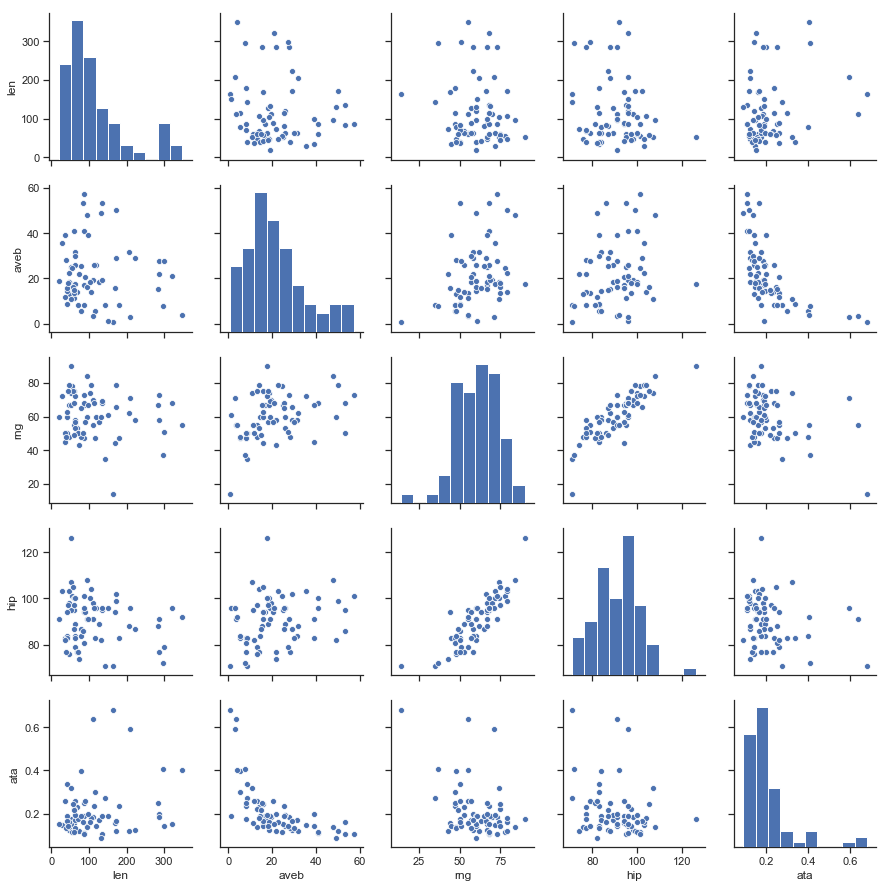

In [23]:
# give the matrix plot to check for good properties of the scalars 
sns.set(style="ticks")
sns.pairplot(db_raw.iloc[ : , ]);

# Distance functions 

For the scalar features, we propose and absolute or and absolute Log Distance Measure, depending if they have strictly higher values than 1. For the interval vector, which summarize the intervals present in a set of pitch classes, we use the IcVSIM - formula proposed by Eric J. Isaacson  in *Issues in the Study of Similarity in Atonal Music* (1996). For features that are captured in histograms we will use the Jensen–Shannon divergence, which is a true distance measure between distributions (contrarily to the commonly used Kullback–Leibler divergence). For the instrument set, we will use the inverse Jaccard Index (1- JD), as it accounts for how many instruments are used in both pieces. 
However, few of our Midi-Files do not provide a signature about the instrument set.  
Regarding the tempo of the bar and the harmony signature, we are not really sure about an appropriate distance measure. For the tempo, we use the Levenstein/Edit-Distance with the argumentation, that a change in numerator and denominator is bigger than a change in only one of them. For the harmony signature, we make the same choice, to capture differences between the key signature. One possibility could be a distance on the circle of fifths, but we are not sure, if this makes sense with respect to music theory.


In [24]:
# Absolute Distance 
def AbsoluteDistance (x, y):
    assert type(x) in [int, float]
    assert type(y) in [int, float]
    return abs(x - y)

# Absolute Log Distance 
def AbsoluteLogDistance(x, y):
    assert type(x) in [int, float]
    assert type(y) in [int, float]
    assert x >= 1
    assert y >= 1
    return abs(np.log(x) - np.log(y))

# Jensen Shannon Divergence ( true distance measure - holds the triangle inequality) -  inspired from Wiki and StackOverflow 
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (st.entropy(_P, _M) + st.entropy(_Q, _M))

# According to Eric J. Isaacson -  Issues in the Study of Similarity in Atonal Music (1996)
def IcVSIM (a,b):
    a = np.sqrt(a)
    b = np.sqrt(b)
    c = a-b 
    return np.std(c)

# Levenstein Distance from Wiki and StackOverflow 
def LD(s,t):
    s = ' ' + str(s)
    t = ' ' + str(t)
    d = {}
    S = len(s)
    T = len(t)
    for i in range(S):
        d[i, 0] = i
    for j in range (T):
        d[0, j] = j
    for j in range(1,T):
        for i in range(1,S):
            if s[i] == t[j]:
                d[i, j] = d[i-1, j-1]
            else:
                d[i, j] = min(d[i-1, j], d[i, j-1], d[i-1, j-1]) + 1
    return d[S-1, T-1]

# inspired from Wiki and StackOverflow 
def JD(a, b):
    a,b = set(a), set(b)
    c = a.intersection(b)
    return  1 - float(len(c)) / (len(a) + len(b) - len(c))

# Intrinsic Dimension and Correlation of Distances

Here, we calculate the intrinsic dimension for each feature, since the distance measurements are symmetric, we only compute the upper half of the spanning matrix, the diagonal equals qua definition 0. Thus, we save some computation. Further, we compare if there exists any correlation between the distancens 

In [25]:
def calc_intrinsic_dim(feature, distance):

    """
    feature is a list with with a descriptive attributes for each midi file

    distance is function that calculates the distances between two midis

    returns the intrinsic dimension as well as an array of distances of the upper matrix
    """
    
    n = len(feature)
    
    # only upper part of matrix
    search_space = list(it.combinations(feature, 2))
    
    # store
    res = []

    # iterate over pairs
    for my_tuple in search_space:
        res.append(distance(my_tuple[0], my_tuple[1]))

    # cast to np  
    res = np.array(res)

    # mean 
    m = sum(res)*2/n**2
    # std  - times 2 because of only upper part 
    sig = ((sum((res**2-m**2)*2) - n* m**2)/n**2)**0.5
    # intrs
    intrs = 0.5*  (m**2)/(sig**2)
    
    return intrs, res


## Intrinsic Dimension
The calculation of the intrinsic dimension for each feature reveals, that the interval vector has the lowest, whereas the pitch histogramm hast the highest value. However, they are not too high. Further, we used the function with the lower dimension for the scalars. 

In [26]:
# Choice of distances as mentioned above
distances = [AbsoluteDistance, AbsoluteDistance,AbsoluteLogDistance,AbsoluteDistance,AbsoluteDistance,
            IcVSIM,  LD, JD, LD,  JSD, JSD] 

columns = list(db_raw)
idms = []
dists = []

# calculate for each feature 
for feature, distance in enumerate(distances):

    idm, dist = calc_intrinsic_dim(db_raw.iloc[:,feature+1 ], distance)
    idms.append(idm)
    dists.append(dist)
    
# already order them for later cdf
distance_matrix = df(dict(zip(columns[1:], dists)), columns=columns[1:])
intrinsic_dims = dict(zip(columns[1:], idms))
intrinsic_dims

{'len': 0.5741116630962149,
 'aveb': 0.7554176681139021,
 'rng': 0.4641343704104046,
 'hip': 0.8157098566551283,
 'ata': 0.36140411535282924,
 'ivv': 0.34074058008685715,
 'harm': 0.7525623233042851,
 'ins': 9.960228570807196,
 'tb': 0.1614270464293614,
 'phist': 1.746574672175917,
 'ihist': 1.6824370479217328}

## Correlation of distances

We display the pairwise correlation matrix between all distance measures. As already found earlier, range and highest pitch exhibit a high correlation. Thus, we decide to drop the highest pitch and keep the range for further computations. Otherwise, pitch histogram and interval histogram have notably positive correlation. Moreover, we provide histograms for the distance distribution of each feature

In [27]:
## Calculate the Correlation Matrix to spot features with too strong correlation
distance_matrix.corr()


,len,aveb,rng,hip,ata,ivv,harm,ins,tb,phist,ihist
len,1.000000,-0.042893,0.005865,-0.014645,0.101452,0.058873,0.147023,-0.001800,0.058961,0.045173,0.021620
aveb,-0.042893,1.000000,0.117377,0.004279,0.288781,-0.021313,0.065062,-0.036192,-0.079595,0.013543,0.108479
rng,0.005865,0.117377,1.000000,0.549302,0.442163,0.080522,-0.009336,0.207363,-0.052756,0.063283,0.177599
hip,-0.014645,0.004279,0.549302,1.000000,0.072937,0.104949,0.049443,0.053867,-0.023606,0.021786,0.146196
ata,0.101452,0.288781,0.442163,0.072937,1.000000,0.327535,-0.018634,0.070871,-0.044732,0.136102,0.291809
ivv,0.058873,-0.021313,0.080522,0.104949,0.327535,1.000000,0.163654,0.017330,0.025616,0.301503,0.187953
harm,0.147023,0.065062,-0.009336,0.049443,-0.018634,0.163654,1.000000,0.001115,0.021057,0.087946,0.052443
ins,-0.001800,-0.036192,0.207363,0.053867,0.070871,0.017330,0.001115,1.000000,0.056580,-0.030352,-0.019706
tb,0.058961,-0.079595,-0.052756,-0.023606,-0.044732,0.025616,0.021057,0.056580,1.000000,0.004299,-0.070228
phist,0.045173,0.013543,0.063283,0.021786,0.136102,0.301503,0.087946,-0.030352,0.004299,1.000000,0.321080


## Distance Distribution 
We see that our distance function for the harmony as well as for the tempo of a bar does not discriminate between the different midi files. Hence, we will drop them as well ! Most of the pieces are in C-Major and have a 4/4, so maybe these features might be more reasonable with a different sample of midis, but the problem of a meaningful distance measure still remains.

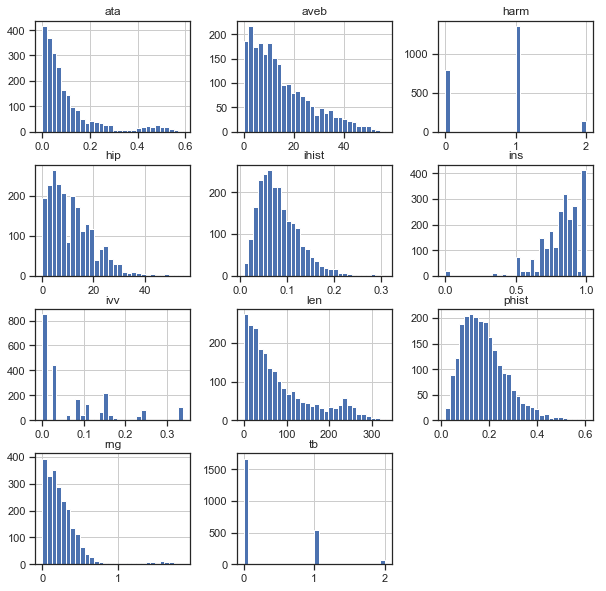

In [28]:
# calculate the percentils 
abc = np.percentile(distance_matrix, np.arange(101), axis = 0)

distance_matrix.hist(bins = 30, figsize = (10,10));

In [29]:
# drop the hip, harm, tb
db_raw = db_raw.drop(['hip', 'harm', 'tb'], axis=1)

# process in list of tuples form for query 
db = list(db_raw.itertuples(index=False, name=None))

## Naive Minimalistic Algorithm
We just reuse the algorithm provided with the instructions.

In [30]:
def zipFeatures (Features):
    """
    Quasi-generalisation of the standard zip(list1, list2, list3...) to zip([sublist1, sublist2, sublist3, ...]).

    Applied to lists of couples, the first component being always the same (the MIDI file name), we return the file name followed by the list of the associated distances/ranks/probabilities.
    """
    assert type(Features) is list
    assert all((type(f) is list
                for f in Features))
    assert all([all([type(t) is tuple and
                     len(t) == 2 and
                     type(t[0]) is str
                     for t in f])
                for f in Features])
    if Features == 0:
        return []
    if len(Features) == 1:
        return [(m[0], [m[1]])
                for m in Features[0]] # transforming the single value into a list with a single value
    else:
        sub_result = zipFeatures(Features[1:])
        assert len(sub_result) == len(Features[0])
        assert all([len(m) == len(Features[0][0])
                    for m in sub_result])
        assert all([m0 == m[0]
                    for ((m0, _), m) in zip(Features[0],
                                            sub_result)])
        return [(m, [f0] + fs)
                    for ((m, f0), (_, fs)) in zip(Features[0],
                                                  sub_result)]

#
# FOR CLARITY (!), NAIVE ALGORITHM WITHOUT COMMENTS, ASSERTIONS, INTERMEDIATE UNSORTED STEPS, NOR PRINTS
#

def QueryByContentShort (Database,
                         Distances,
                         Query):
    Features = [[(m[0], m[f + 1])
                 for m in Database]
                for f in range(len(Distances))]
    IncreasingDistances = [sorted([(distance_f(query_f, f), m)
                                   for (m, f) in feature_f])
                           for (distance_f, query_f, feature_f) in zip(Distances,
                                                                       Query[1:],
                                                                       Features)]
    Aligned = [sorted([(m, i)
                       for (i, (d, m)) in zip(range(len(f)),
                                              f)])
              for f in IncreasingDistances]
    return sorted([(sum(ranks), d)
                   for ((m, ranks), d) in zip(zipFeatures(Aligned),
                                              Database)])


## Execution of Naive Algorithm
We exemplarily execute the algorithm for one query. We choose a Star Trek Theme, since we also have other Start Trek Themes ("Voyageur, Next Generation, Deep Space Nine) in our database. Ideally, we would find them on the very top of the results. However, the results are not that satisfying, as we see the next Star Trek Song on spot 12, even though the sound is similar. Hawaii_50 is actually not too different soundwise, but the other songs occur almost a bit randomly. One reason might that some features are not to discriminant. In the following, we reduce to lower features and try to get a higher precision! 

In [31]:
# Star Trek       #len', 'rng', 'ata', 'ivv', 'ins', 'phist', 'ihist'
Query = db[47]

# CHoices like above - removed hip, harm, and tb !
Distances =  [AbsoluteDistance, AbsoluteDistance,AbsoluteLogDistance,AbsoluteDistance,
            IcVSIM,  JD, JSD, JSD]



NUMBER_OF_ANSWERS = 20

print("=" * 100 )
print("Query:", Query)
print("Up to first", NUMBER_OF_ANSWERS, "answers:")
for (i, answer) in zip(range(1, NUMBER_OF_ANSWERS + 1),
                       QueryByContentShort(db, Distances, Query)):
    print("   ", i,answer[0], answer[1][0])
print("=" * 100 )


Query: ('Star_Trek.mid', 59.75355931666621, 13.388323794409805, 75, 0.2211021505376344, [12, 12, 12, 12, 12, 6], {'Harp', 'Trumpet', 'Piano', 'Voice', 'Clarinet', 'Trombone', None, 'Horn', 'Acoustic Bass', 'Piccolo'}, [36, 35, 55, 108, 9, 90, 109, 47, 24, 37, 163, 87], [182, 50, 21, 41, 40, 50, 18, 26, 42, 9, 8, 4])
Up to first 20 answers:
    1 25 Star_Trek.mid
    2 126 Hawaii_50.mid
    3 139 The_Outer_Limits.mid
    4 154 Frasier.mid
    5 168 Dick_Van_Dyke.mid
    6 170 The_Muppet_Show.mid
    7 174 I_Love_Lucy.mid
    8 184 Seinfeld.mid
    9 190 The_Jetsons.mid
    10 192 Bewitched.mid
    11 196 Charlie_Brown.mid
    12 199 Star_Trek_-_The_Next_Generation.mid
    13 204 90210.mid
    14 204 I_Dream_Of_Jeannie.mid
    15 204 Tiny_Toons.mid
    16 205 Mash.mid
    17 208 Get_Smart.mid
    18 224 Tales_From_The_Crypt.mid
    19 225 Benjy_shelton__-_Lazy_Town_We_are_number_one_.mid
    20 225 Pokemon.mid


### Using less features
We rerun the query but with less features. Nonetheless, the results seem to only slightly improve. Again Hawai has the first spot, whereas Star-Trek the next generation moves up to spot 7. Again, the other two Star Trek Themes are not in the top 20 despite their similarity to the queried song. We obeserve this behaviour for various queries. The result are never satisfying. Neither precision nor recall are high.

In [32]:
## subset less features 

dbs = db_raw[['piece', 'ihist', 'ins', 'ata', 'phist', 'len' ]]
dbb = list(dbs.itertuples(index=False, name=None))


# Star Trek 
Query = dbb[47]

# CHoices like above - removed HIP !
Distances = [JSD, JD, AbsoluteDistance, JSD, AbsoluteDistance] 

NUMBER_OF_ANSWERS = 20

print("=" * 100 )
print("Query:", Query)
print("Up to first", NUMBER_OF_ANSWERS, "answers:")
for (i, answer) in zip(range(1, NUMBER_OF_ANSWERS + 1),
                       QueryByContentShort(dbb, Distances, Query)):
    print("   ", i,answer[0], answer[1][0])
print("=" * 100 )



Query: ('Star_Trek.mid', [182, 50, 21, 41, 40, 50, 18, 26, 42, 9, 8, 4], {'Harp', 'Trumpet', 'Piano', 'Voice', 'Clarinet', 'Trombone', None, 'Horn', 'Acoustic Bass', 'Piccolo'}, 0.2211021505376344, [36, 35, 55, 108, 9, 90, 109, 47, 24, 37, 163, 87], 59.75355931666621)
Up to first 20 answers:
    1 0 Star_Trek.mid
    2 69 Hawaii_50.mid
    3 78 The_Jetsons.mid
    4 83 Pokemon.mid
    5 90 The_Outer_Limits.mid
    6 91 Frasier.mid
    7 99 I_Love_Lucy.mid
    8 99 Star_Trek_-_The_Next_Generation.mid
    9 101 Get_Smart.mid
    10 105 Tiny_Toons.mid
    11 111 The_Muppet_Show.mid
    12 121 Seinfeld.mid
    13 122 Dick_Van_Dyke.mid
    14 123 Tales_From_The_Crypt.mid
    15 128 90210.mid
    16 131 Charlie_Brown.mid
    17 136 7th_Heaven.mid
    18 136 The_Simpsons.mid
    19 137 Mash.mid
    20 140 Love_Boat.mid


## Change rank to Probabilistic Ordering 

For each of the remaining features (len', 'rng', 'ata', 'ivv', 'ins', 'phist', 'ihist') we try to find the best estimate of the CDF in order to retrieve the percentil for a given distance faster. Thus, we try to find the best fit for a set of more roughly 50 density distributions and store the corresponding parameters. The helper function is inspired from [here](https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python#). We first show the fitting Distribution and store the corresponding parameters

In [33]:
# get the best fit for a set of distributions
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python#

def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha, st.beta,st.betaprime,st.chi,st.chi2,st.cosine,st.dgamma,st.expon,st.exponnorm,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,st.logistic,st.loggamma,
        st.loglaplace, st.nct,st.norm,st.pareto,st.powerlaw,st.powernorm,st.wald
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = s(y, x)

    return pdf




In [34]:
# own implementation to query for p-v and helpers to plot 

def get_cdf(dist, params, x):
    
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # get p for given cdf
    p = dist.cdf(x, *arg, loc=loc, scale=scale)

    return p

def get_dists(array, bins = 50):
    
    # calculate best
    best_fit_name, best_fit_params = best_fit_distribution(array, bins)
    
    # get the best parameter
    best_dist = getattr(st, best_fit_name)
    
    return best_dist,best_fit_params, best_fit_name
    
    
def plot_dists(best_dist, best_fit_params, array, best_fit_name, label = "feature", bins = 50):
    
    # calculate the prob for drawing
    pdf = make_pdf(best_dist, best_fit_params)
    
    # Display
    plt.figure(figsize=(4,4))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    array.plot(kind='hist', bins=bins, density=True, alpha=0.5, label='Data', legend=True, ax=ax);

    # param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    #param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_name)])
    #dist_str = '{}({})'.format(best_fit_name, param_str)
    #param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    #param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
   # dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(label + u' \n' +  best_fit_name)
    ax.set_xlabel(u'Distance')
    ax.set_ylabel('Frequency')
    
    return 
    
    


### Density estimation
For the remaining features, we estimate the best fitting distribution, store the results and display the corresponding plots. Note that with a choice of 50 bins, the plot for the Interval Vector is displayed empty, since the distribution is concentrated on sevaral points. If computational resources are poor, one might reduce the number of density distributions that are checked. At the end, we can compute the percentil of a given distance for a feature with the *get_cdf* -method.

In [ ]:
# calculate for each feature 
features = list(db_raw.columns.values)[1:]

# get results in a as lists of tuples
dens_approx = []

for i, feature in enumerate(features):
    
    # get column of distance matrix 
    x = distance_matrix[feature]
    
    bins = 50
    if (feature == "ivv"):
        bins = 10
    
    # estimate best distribution and plot 
    best_dist,best_fit_params, best_fit_name = get_dists(x, bins = bins)
    plot_dists(best_dist,best_fit_params,x,feature, best_fit_name, bins = bins)

    dens_approx.append((feature,best_dist,best_fit_params))

## Querying using a probabilistic approach

With the density estimation, we can evaluate the distance between two midis in a probabilistic way (i.e. the products of the probabilities for each feature, how likely it is to have a smaller or equal distance as the observed one). A common trick for numeric stability is the use of the sum of the negative logs. Thus, we are looking for high values, as they indicate a relatively higher similarity. Thus, we changed the naive algorithm from above and implemented the probability estimation instead of the pure rank assignment.


In [25]:
#
# NAIVE ALGORITHM - changed to use the sum of the negative logs of the percentiles 
#

# log transformation - add epsilon for 0, to avoid -inf !! 
def log_trans(x): 
    if np.isclose(x,0):
        x += 1e-50
    return( - np.log(x))

def QueryByContentProbs (Database,
                    Distances,
                    Query, 
                    Approximation = None):
    """
    Database is a list of tuples, consisting of the MIDI file name followed by n feature values.

    Distances is a list of distance *functions*, one for each feature.
    
    Approximation is a list of tuples with estimated density distributions for the distances of the corresponding features

    Query is a tuple, of the same form as the ones in Database.
    """
   
     # Firstly, we separate the features into their own lists in order to simplify the following steps (a.k.a. relational denormalisation)
    Features = [[(m[0], m[f + 1])
                 for m in Database]
                for f in range(len(Distances))]

    # For each MIDI file m, for each feature f,
    #    - compute the distance d_f(q, m_f);
    DistancesEvaluation = [[(distance_f(query_f, f), m)
                            for (m, f) in feature_f]
                           for (distance_f, query_f, feature_f) in zip(Distances,
                                                                       Query[1:],
                                                                       Features)]
    # We retrieve the percentil and transform it to the negative log
    Distanz_as_log_percentil = [[(m, log_trans(get_cdf(approx[1], approx[2],dist)) )
                      for (dist,m) in distance_f]
                      for (approx,distance_f) in zip(Approximation, DistancesEvaluation)]
    
    

    # We take the sum (actually products) --> which means that higher values indicate more similatiry
    return sorted([(sum(probs),m,c) for 
             ((m, probs),c) in zip(zipFeatures(Distanz_as_log_percentil), Database)], reverse = True)


def zipFeatures (Features):
    """
    Quasi-generalisation of the standard zip(list1, list2, list3...) to zip([sublist1, sublist2, sublist3, ...]).

    Applied to lists of couples, the first component being always the same (the MIDI file name), we return the file name followed by the list of the associated distances/ranks/probabilities.
    """
    assert type(Features) is list
    assert all((type(f) is list
                for f in Features))
    assert all([all([type(t) is tuple and
                     len(t) == 2 and
                     type(t[0]) is str
                     for t in f])
                for f in Features])
    if Features == 0:
        return []
    if len(Features) == 1:
        return [(m[0], [m[1]])
                for m in Features[0]] # transforming the single value into a list with a single value
    else:
        sub_result = zipFeatures(Features[1:])
        assert len(sub_result) == len(Features[0])
        assert all([len(m) == len(Features[0][0])
                    for m in sub_result])
        assert all([m0 == m[0]
                    for ((m0, _), m) in zip(Features[0],
                                            sub_result)])
        return [(m, [f0] + fs)
                    for ((m, f0), (_, fs)) in zip(Features[0],
                                                  sub_result)]

## Repetition of the Query - Probablistic Approach 

We repeat the same query on the Star Trek Theme but now with the new probabilistic approach. The results are not convincing on the first view. The 'Outer Limits' moves on spot 2 and 'Hawaai', formerly on spot 2, has moved to spot 4. However, again only one additional Star Trek Theme is in the Top 20. We would have assumed better results, our precision and our recall are low! This holds true for other queries that we ask against the database. 

In [26]:
# Star Trek       #len', 'rng', 'ata', 'ivv', 'ins', 'phist', 'ihist'
Query = db[47]

# CHoices like above - removed hip, harm, and tb !
Distances =  [AbsoluteDistance, AbsoluteDistance,AbsoluteLogDistance,AbsoluteDistance,
            IcVSIM,  JD, JSD, JSD]



NUMBER_OF_ANSWERS = 20

print("=" * 100 )
print("Query:", Query)
print("Up to first", NUMBER_OF_ANSWERS, "answers:")
for (i, answer) in zip(range(1, NUMBER_OF_ANSWERS + 1),
                       QueryByContentProbs(db, Distances, Query,dens_approx)):
    print("   ", i, round(answer[0],2) ,answer[1])
print("=" * 100 )


Query: ('Star_Trek.mid', 59.75355931666621, 13.388323794409805, 75, 0.2211021505376344, [12, 12, 12, 12, 12, 6], {'Acoustic Bass', 'Clarinet', 'Harp', 'Trombone', 'Voice', 'Piccolo', None, 'Piano', 'Horn', 'Trumpet'}, [36, 35, 55, 108, 9, 90, 109, 47, 24, 37, 163, 87], [182, 50, 21, 41, 40, 50, 18, 26, 42, 9, 8, 4])
Up to first 20 answers:
    1 499.45 Star_Trek.mid
    2 31.12 The_Outer_Limits.mid
    3 25.72 X_Files.mid
    4 18.82 Hawaii_50.mid
    5 17.49 Tiny_Toons.mid
    6 17.01 Frasier.mid
    7 16.59 The_Jetsons.mid
    8 15.45 7th_Heaven.mid
    9 14.61 I_Love_Lucy.mid
    10 14.42 The_Muppet_Show.mid
    11 13.14 Mash.mid
    12 12.63 Get_Smart.mid
    13 12.58 Star_Trek_-_The_Next_Generation.mid
    14 12.26 Pokemon.mid
    15 12.23 I_Dream_Of_Jeannie.mid
    16 12.19 The_Wonder_Years_-_With_A_Little_Help_From_My_Friends.mid
    17 11.94 Tales_From_The_Crypt.mid
    18 11.94 Seinfeld.mid
    19 11.71 The_Simpsons.mid
    20 11.71 Dick_Van_Dyke.mid


## Remarks and Conclusion
We selected several features and proposed different distance functions, that might serve to detect similarities between midi files. During the building process, we discovered quickly that some of them were not meaningful as they had a low variation or as we could not find a reasonable distance function, so that we dropped them. Based on the remaining features, we tried to find similar music pieces. Despite some variation within the features and a low intrinsic dimension, our results were quite poor with a simple ranking algorithm. As consequence we tried to estimate the distance distribution for features by density distributions, allowing to provide probabilistic judgement on the quality of a distance. We provided a way to find a fitting density distribution out of over 50 distributions. Nonetheless, the results are not sufficient. Even though we only present one example, our experiments with various midi files were dissapointing.  Possibly, our selection of only Tv-Themes might have  biased the results (despite the variation in features). Hence, our proposal would be to a) draw another sample of midi files that should be as unbiased as possible and b) to spend more time on the definition of relevant music features and appropriate distance measures. 